In [1]:
import ee
import folium
import geopandas as gpd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, losses, models, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
BANDS = ["b1"]
RESPONSE = "FAULTLINE"
FEATURES = BANDS + [RESPONSE]

KERNEL_SIZE = 128
COLUMNS = [
    tf.io.FixedLenFeature(shape=[KERNEL_SIZE, KERNEL_SIZE], dtype=tf.float32) for _ in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [3]:
def parse_tfrecord(example_proto):
    """The parsing function.
    Read a serialized example into the structure defined by FEATURES_DICT.
    Args:
    example_proto: a serialized Example.
    Returns:
    A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = [inputs.get(key) for key in FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(BANDS)], tf.squeeze(tf.cast(stacked[:,:,len(BANDS):], tf.int32))


def get_dataset(pattern):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

In [4]:
tf.random.set_seed(42)

#  1. Get Data

In [5]:
BATCH_SIZE = 16
BUFFER_SIZE = 2000

base_path = "gs://esg-satelite-data-warehouse/mars/modelling/themis_tempeterra_epsg3857_v1"
#base_path = "gs://esg-satelite-data-warehouse/mars/modelling/themis_tempeterra_500_64"


train_data_path = f"{base_path}/modelling_data_train.tfrecord.gz"
test_data_path = f"{base_path}/modelling_data_test.tfrecord.gz"
val_data_path = f"{base_path}/modelling_data_val.tfrecord.gz"

train_data_raw = get_dataset(train_data_path)
test_data_raw = get_dataset(test_data_path)
val_data_raw = get_dataset(val_data_path)


training_data = train_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)
test_data = test_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)
val_data = val_data_raw.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False).batch(BATCH_SIZE)

2023-10-09 16:39:09.406312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 16:39:09.418754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 16:39:09.420408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 16:39:09.422667: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128), dtype=tf.int32, name=None))>

# 2. Define model

In [7]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

def get_model():

    normalisation_layer = layers.Normalization()
    normalisation_layer.adapt(training_data.map(lambda x, _: x))

    inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
    normalised_inputs = normalisation_layer(inputs)
    encoder0_pool, encoder0 = encoder_block(normalised_inputs, 32) # 128
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
    center = conv_block(encoder4_pool, 1024) # center
    decoder4 = decoder_block(center, encoder4, 512) # 16
    decoder3 = decoder_block(decoder4, encoder3, 256) # 32
    decoder2 = decoder_block(decoder3, encoder2, 128) # 64
    decoder1 = decoder_block(decoder2, encoder1, 64) # 128
    decoder0 = decoder_block(decoder1, encoder0, 32) # 256
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.SGD(learning_rate=1), 
        loss=losses.BinaryCrossentropy(),
        metrics=[
            metrics.BinaryIoU(target_class_ids=[1], name = "iou")
        ]
    )
    return model

# 3. Training

In [8]:
callbacks = []
es = EarlyStopping(
    monitor= "val_iou",
    patience=5,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)
callbacks.append(es)

In [9]:
model = get_model()

EPOCHS = 10

history = model.fit(
    x=training_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks = callbacks
)

Epoch 1/10


2023-10-09 16:39:20.300166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2023-10-09 16:39:21.220245: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2023-10-09 16:39:21.220291: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-10-09 16:39:21.220684: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handl

NotFoundError: Graph execution error:

Detected at node 'model/conv2d/Conv2D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/tmp/ipykernel_49387/4293578456.py", line 5, in <module>
      history = model.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d/Conv2D'
2 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 4#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 4: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 6#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 6: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 7#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 7: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node model/conv2d/Conv2D}}]]
	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_57]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), inpu [Op:__inference_train_function_6286]

In [60]:
model.save("gs://esg-satelite-data-warehouse/mars/models/sample_model_1")

INFO:tensorflow:Assets written to: gs://esg-satelite-data-warehouse/mars/models/sample_model_1/assets


INFO:tensorflow:Assets written to: gs://esg-satelite-data-warehouse/mars/models/sample_model_1/assets


In [9]:
#model.summary()

# 4. Results

In [16]:
def plot_results(x_train, y_train, x_pred_prob, x_pred_binary, title):
    fig, axs = plt.subplots(2,2)
    
    axs[0, 0].imshow(x_train)
    _ = axs[0, 0].axis('off')
    _ = axs[0, 0].set_title('Real Image') 
    
    axs[0, 1].imshow(y_train)
    _ = axs[0, 1].axis('off')
    _ = axs[0, 1].set_title('Real Faults')
    
    axs[1, 0].imshow(x_pred_prob)
    _ = axs[1, 0].axis('off')
    _ = axs[1, 0].set_title('Predicted Fault (prob)')
    
    axs[1, 1].imshow(x_pred_binary)
    _ = axs[1, 1].axis('off')
    _ = axs[1, 1].set_title('Predicted Fault (bin)')
    
    plt.suptitle(title)

In [17]:
def get_model_results(model, data, n_images = 1, thresh = 0.5):
    # NOTE: Make sure "reshuffle_each_iteration = False" in data.shuffle(...)
    for i in range(n_images):
        # Get data
        x_train = np.expand_dims(np.concatenate([x for x, _ in data], axis=0)[i], axis=0)
        y_train = np.expand_dims(np.concatenate([y for _, y in data], axis=0)[i], axis=0)
        # Get predictions
        x_pred_prob = model.predict(x_train)
        x_pred_binary = (x_pred_prob > thresh)*1
        # Get IOU metric
        iou_metric = metrics.BinaryIoU(target_class_ids=[1], name = "iou")
        iou_metric.update_state(y_true=y_train, y_pred=x_pred_prob)
        iou_value = iou_metric.result().numpy()
        
        plot_results(x_train[:,:,:,:1].squeeze(), y_train[0], x_pred_prob[0], x_pred_binary[0], title = f"IOU: {iou_value}") 

1/1 [==============================] - 0s 26ms/step


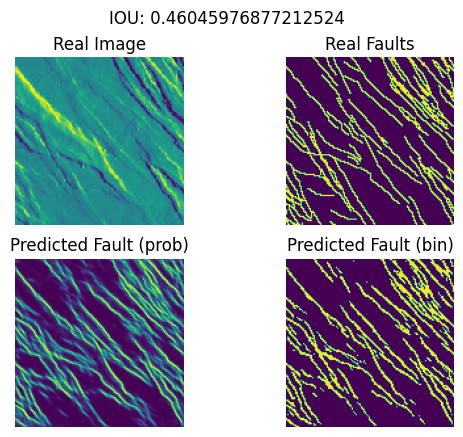

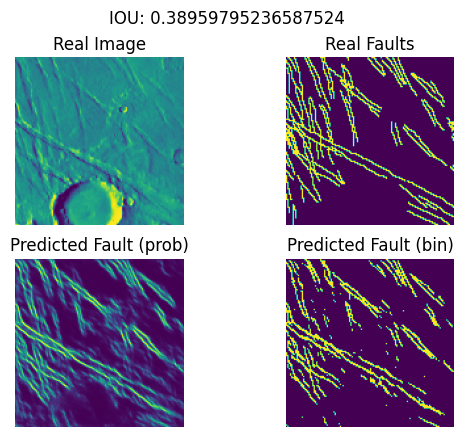

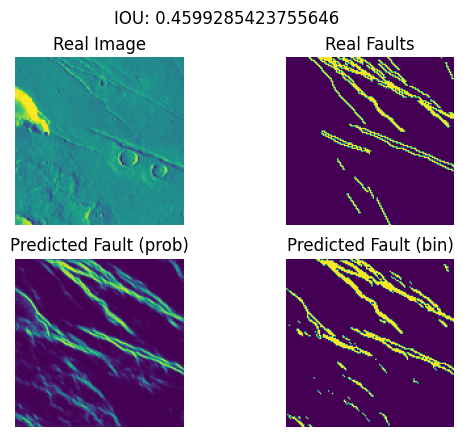

In [25]:
get_model_results(model = model, data = test_data, n_images = 3, thresh = 0.45)

1/1 [==============================] - 0s 26ms/step


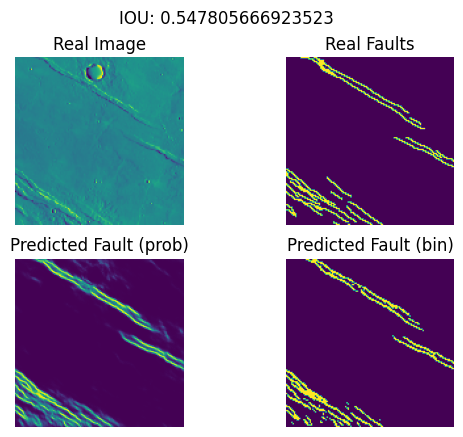

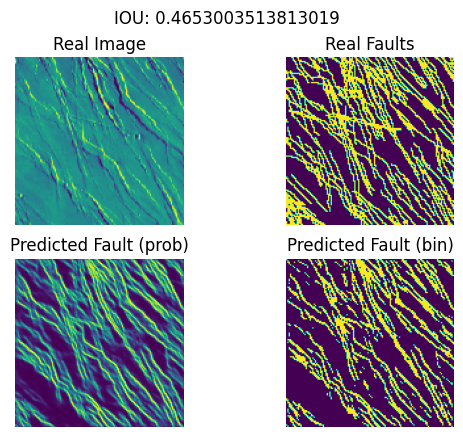

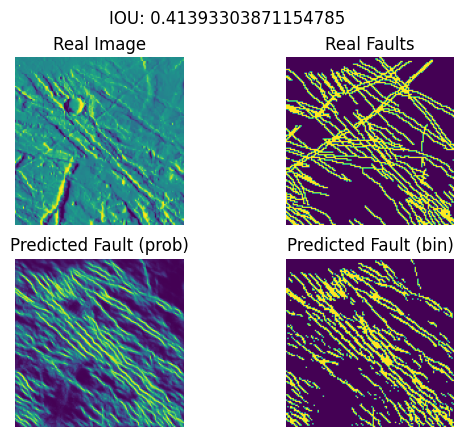

In [13]:
get_model_results(model = model, data = val_data, n_images = 3, thresh = 0.25)

# 5. Apply Random Classifier

In [14]:
def random_classifier(training):
    y_train = np.concatenate([y for _, y in training], axis=0)
    output_shape = list(y_train.shape)

    y_random = np.random.randint(0, 2, output_shape)

    iou_metric = metrics.IoU(num_classes=2, target_class_ids=[1])
    iou_metric.update_state(y_true=y_train, y_pred=y_random)
    iou_value = iou_metric.result().numpy()
    return iou_value

In [15]:
random_classifier(training)

NameError: name 'training' is not defined

# 6. Outputting as GeoTIFF

In [28]:
import rasterio
from rasterio.transform import from_origin

In [37]:
data = test_data

x_test = np.expand_dims(np.concatenate([x for x, _ in data], axis=0)[0], axis=0)
y_test = np.expand_dims(np.concatenate([y for _, y in data], axis=0)[0], axis=0)

In [40]:
x_pred_prob = model.predict(x_test)
x_pred_binary = (x_pred_prob > 0.5)*1

1/1 [==============================] - 0s 212ms/step


In [42]:
x_pred_binary.shape

(1, 128, 128, 1)

In [45]:
x_pred_binary_squeezed = x_pred_binary.squeeze()

In [50]:
new_dataset = rasterio.open(
    "test1.tif",
    "w",
    driver="GTiff",
    height = x_pred_binary_squeezed.shape[0],
    width = x_pred_binary_squeezed.shape[1],
    count=1,
    dtype = str(x_pred_binary_squeezed.dtype),
    #crs =,
    #transform =
)
new_dataset.write(x_pred_binary_squeezed,1)
new_dataset.close()

In [ ]:
"""
image = rasterio.read(input_geotiff.tif) <- numpy array
crs = image.crs

prediction = model.predict(image) <- numpy array

rasterio.write(output_geotiff.tif, prediction, crs)

"""